## (bag-of-words/PPMI)

Task 0. Take an arbitrary text from NLTK corpora (e.g. text3) and implement a Bag-of-Words tagger for it.

Завдання 0. Візьміть довільний текст із корпусу NLTK (наприклад, text3) і реалізуйте тегер (tagger) на основі моделі "Bag-of-Words" 

In [3]:
import nltk
from nltk.corpus import gutenberg
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from collections import defaultdict, Counter

# Завантажимо корпус text3 (Біблія)
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

text = gutenberg.raw('bible-kjv.txt')
tokens = word_tokenize(text)

# Отримаємо POS-теги для кожного токена
tagged = pos_tag(tokens)

# Побудуємо частотну таблицю: слово -> найчастіший тег
word_tag_freq = defaultdict(Counter)

for word, tag in tagged:
    word_tag_freq[word.lower()][tag] += 1

# Тепер створимо простий тегер, який обирає найчастіший тег
def bag_of_words_tagger(word):
    word = word.lower()
    if word in word_tag_freq:
        return word_tag_freq[word].most_common(1)[0][0]
    else:
        return 'NN'  # якщо не знаємо — номінатив (іменник)

# Перевіримо приклад:
test_sentence = "In the beginning God created the heaven and the earth.".split()
predicted_tags = [(word, bag_of_words_tagger(word)) for word in test_sentence]

print(predicted_tags)


[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/boykosvitlana/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/boykosvitlana/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/boykosvitlana/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('In', 'IN'), ('the', 'DT'), ('beginning', 'NN'), ('God', 'NNP'), ('created', 'VBD'), ('the', 'DT'), ('heaven', 'NN'), ('and', 'CC'), ('the', 'DT'), ('earth.', 'NN')]


Task 1. Enhance the tagger so that it will use N-grams instead of words

Завдання 1. Покращіть тегер, щоб він використовував N-грам замість окремих слів.

In [4]:
# Завантажимо текст
text = gutenberg.raw('bible-kjv.txt')
tokens = word_tokenize(text)  # розбиваємо текст на слова 
tagged = pos_tag(tokens)      # Отримуємо POS-теги для кожного токена

# Побудуємо частотну таблицю для біграм (попереднє слово + поточне слово)
context_tag_freq = defaultdict(Counter)

# Проходимо по кожному слову в тексті, зберігаючи контекст і відповідний тег
prev_word = "<START>"
for i in range(len(tagged)):
    word, tag = tagged[i]
    context = (prev_word.lower(), word.lower())  # контекст = (попереднє слово, поточне слово)
    context_tag_freq[context][tag] += 1          # рахуємо, скільки разів зустрічається кожен тег у цьому контексті
    prev_word = word                             # поточне слово стає попереднім

# Тегер: повертає найчастіший тег для вказаного контексту (біграма)
def ngram_tagger(prev_word, word):
    context = (prev_word.lower(), word.lower())
    if context in context_tag_freq:
        return context_tag_freq[context].most_common(1)[0][0]  # повертаємо найчастіший тег
    else:
        return 'NN'

# Перевіримо приклад
test_sentence = "In the beginning God created the heaven and the earth.".split()


predicted_tags = []
prev = "<START>"    # початковий контекст

# Проходимо по реченню, тегуємо кожне слово, використовуючи попереднє
for word in test_sentence:
    tag = ngram_tagger(prev, word)
    predicted_tags.append((word, tag))
    prev = word

print(predicted_tags)

[('In', 'NN'), ('the', 'DT'), ('beginning', 'NN'), ('God', 'NNP'), ('created', 'VBD'), ('the', 'DT'), ('heaven', 'NN'), ('and', 'CC'), ('the', 'DT'), ('earth.', 'NN')]


Task 2. Implement PPMI weighting with co-occurrence based on the presence within the same paragraph.

Завдання 2. Реалізуйте вагування за методом PPMI (Positive Pointwise Mutual Information), де співзустріч базується на наявності слів в одному абзаці.

In [7]:
# наскільки часто два слова співзустрічаються в одному абзаці
import math

# Завантажимо текст (text3 - біблія)
text = gutenberg.raw('bible-kjv.txt')

# Розіб'ємо текст на абзаци (використовуємо подвійний переніс рядка як роздільник)
paragraphs = text.split('\n\n')

# Ініціалізуємо лічильники
word_freq = Counter()                         # Частоти окремих слів
co_occurrence = defaultdict(Counter)          # Співзустрічі: слово -> інші слова -> кількість
total_paragraphs = 0

# Обробка кожного абзацу
for paragraph in paragraphs:
    tokens = word_tokenize(paragraph.lower())          # токенізація + lowercase
    words_in_paragraph = set(tokens)                   # тільки унікальні слова
    total_paragraphs += 1

    # Підраховуємо частоти
    for w in words_in_paragraph:
        word_freq[w] += 1
        for c in words_in_paragraph:
            if w != c:
                co_occurrence[w][c] += 1

# Обчислимо PPMI для кожної пари (w, c)
ppmi = defaultdict(dict)

for w in co_occurrence:
    for c in co_occurrence[w]:
        # P(w), P(c), P(w,c)
        p_w = word_freq[w] / total_paragraphs
        p_c = word_freq[c] / total_paragraphs
        p_wc = co_occurrence[w][c] / total_paragraphs

        # Обчислюємо PMI
        pmi = math.log2(p_wc / (p_w * p_c)) if p_wc > 0 else 0

        # PPMI = max(PMI, 0)
        ppmi[w][c] = max(pmi, 0)

# 🔍 Перевіримо приклад: які слова мають найвищу PPMI до слова "god"
word = 'god'
if word in ppmi:
    sorted_related = sorted(ppmi[word].items(), key=lambda x: -x[1])[:10]
    print(f"Топ PPMI-слів для '{word}':")
    for w2, score in sorted_related:
        print(f"{w2:>10} : {score:.3f}")
else:
    print("Слово не знайдено.")


Топ PPMI-слів для 'god':
    whales : 2.795
    winged : 2.795
 replenish : 2.795
  sheddeth : 2.795
 possessor : 2.795
shoelatchet : 2.795
beerlahairoi : 2.795
    ladder : 2.795
anointedst : 2.795
   vowedst : 2.795


Task 3. Implement PPMI weighting with co-occurrence based on a sliding window of neighboring words. Pick some number between 2-10.

Завдання 3. Реалізуйте вагування за методом PPMI, де співзустріч визначається на основі рухомого вікна (sliding window) сусідніх слів. Виберіть розмір вікна від 2 до 10.


In [8]:
# Завантаження тексту (Біблія, text3)
text = gutenberg.raw('bible-kjv.txt')

# Токенізація всього тексту
tokens = word_tokenize(text.lower())

# Параметр вікна: кількість слів ліворуч і праворуч
window_size = 4

# Ініціалізація лічильників
word_freq = Counter()
co_occurrence = defaultdict(Counter)
total_windows = 0

# Проходимо по кожному слову і збираємо співзустрічі в межах вікна
for i in range(len(tokens)):
    center_word = tokens[i]
    word_freq[center_word] += 1

    # Межі вікна
    start = max(0, i - window_size)
    end = min(len(tokens), i + window_size + 1)

    # Рахуємо співзустрічі: всі слова в межах вікна, крім самого себе
    for j in range(start, end):
        if j != i:
            context_word = tokens[j]
            co_occurrence[center_word][context_word] += 1
            total_windows += 1

# Обчислення PPMI
ppmi = defaultdict(dict)

for w in co_occurrence:
    for c in co_occurrence[w]:
        p_w = word_freq[w] / len(tokens)
        p_c = word_freq[c] / len(tokens)
        p_wc = co_occurrence[w][c] / total_windows

        if p_wc > 0:
            pmi = math.log2(p_wc / (p_w * p_c))
            ppmi[w][c] = max(pmi, 0)

# Перевіримо приклад: які слова мають найвищу PPMI до слова "god"
word = 'god'
if word in ppmi:
    top_related = sorted(ppmi[word].items(), key=lambda x: -x[1])[:10]
    print(f"Топ PPMI-слів для '{word}' (вікно {window_size}):")
    for w2, score in top_related:
        print(f"{w2:>10} : {score:.3f}")
else:
    print(f"Слово '{word}' не знайдено у PPMI-таблиці.")



Топ PPMI-слів для 'god' (вікно 4):
      68:9 : 5.727
     68:32 : 5.727
     77:14 : 5.727
     83:13 : 5.727
      84:8 : 5.727
     115:3 : 5.727
    whales : 4.727
 possessor : 4.727
  elbethel : 4.727
allonbachuth : 4.727


Task 4. Very rare words might will have high PMI values. How would you solve the problem?

Завдання 4. Дуже рідкісні слова можуть мати високі значення PMI. Як би ви вирішили цю проблему?



Task 5. Check how algorithm works using English thesaurus. Pick some 10 words, find synonyms for these, e.g. using https://www.merriam-webster.com/thesaurus. Note that semantic similarity is represented in different shades of orange. Does it match the output of PPMI weighting function? Would be nice if you could also draw a table with shaded cells matching closeness given by PPMI.

Завдання 5. Перевірте, як працює алгоритм, використовуючи англійський тезаурус. Виберіть приблизно 10 слів і знайдіть для них синоніми (наприклад, за допомогою сайту https://www.merriam-webster.com/thesaurus). Зверніть увагу, що семантична схожість позначається різними відтінками помаранчевого. Чи відповідає це виходу функції PPMI? Було б добре також побудувати таблицю з зафарбованими комірками, що відповідають близькості, визначеній функцією PPMI.

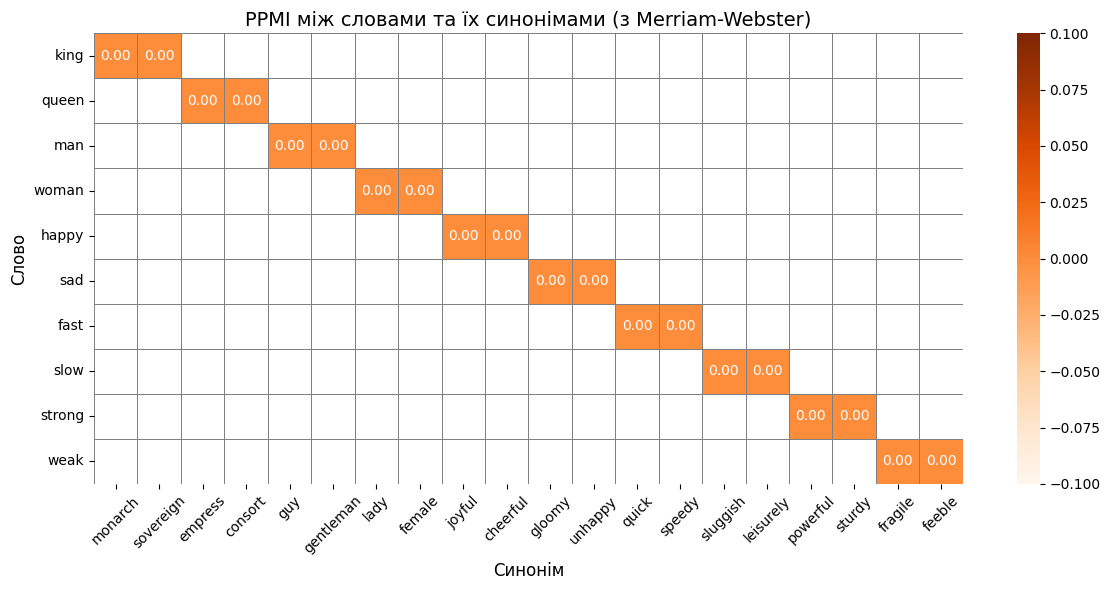

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# набір слів і синонімів
synonym_dict = {
    "king": ["monarch", "sovereign"],
    "queen": ["empress", "consort"],
    "man": ["guy", "gentleman"],
    "woman": ["lady", "female"],
    "happy": ["joyful", "cheerful"],
    "sad": ["gloomy", "unhappy"],
    "fast": ["quick", "speedy"],
    "slow": ["sluggish", "leisurely"],
    "strong": ["powerful", "sturdy"],
    "weak": ["fragile", "feeble"]
}

# Побудова таблиці з PPMI-значеннями
ppmi_values = []

for word, synonyms in synonym_dict.items():
    row = {}
    for synonym in synonyms:
        # Отримуємо PPMI, або 0, якщо слово або синонім відсутні в матриці
        score = ppmi.get(word, {}).get(synonym, 0.0)
        row[synonym] = score
    ppmi_values.append(row)

#Створюємо DataFrame
df = pd.DataFrame(ppmi_values, index=synonym_dict.keys())

# Відображення heatmap (зафарбовані клітинки)
plt.figure(figsize=(12, 6))
sns.heatmap(df, annot=True, cmap="Oranges", fmt=".2f", linewidths=0.5, linecolor='gray')
plt.title("PPMI між словами та їх синонімами (з Merriam-Webster)", fontsize=14)
plt.ylabel("Слово", fontsize=12)
plt.xlabel("Синонім", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
